In [50]:
import pandas as pd
import numpy as np
import random 
from itertools import product, combinations
import copy
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time
import matplotlib.pyplot as plt
def get_domains(data):
	#TODO: get domains from file
	return None

# 1. La conception du modèle

In [2]:
class Data:
	def __init__(self, variable_data, N, f, mydata=None, mydomains=None,verbose=False):
		if mydata is None:
			self.data = pd.DataFrame(self.generate_random_data(variable_data, N))
		else:
			self.data = mydata
		if mydomains is None:
			self.domains = self.extract_domains(variable_data)
		else:
			self.domains = mydomains
		self.data['y'] = self.data.apply(lambda row: f(*row[1:]), axis=1)
		self.f = f
		if verbose:
			print("Données récupérées avec succés !")

	def generate_random_data(self, variable_data, N=10):
		data = {}
		data['id'] = range(N)
		
		for i, variable in enumerate(variable_data):
			name = variable['name']
			var_type = variable['type']
			step = int(variable['step']) if variable['step'] else 0

			if var_type == 'boolean':
				data[name] = [random.choice([False, True]) for _ in range(N)]
			else:
				if var_type=='int':
					min_value = int(variable['min'])
					max_value = int(variable['max'])
					mean = np.random.uniform(((5*min_value+3*max_value)/8)*1.2, ((3*min_value+5*max_value)/8)*1.2)
					std = np.random.uniform((max_value-min_value)/15, (max_value-min_value)/5)
					data[name]  = np.random.normal(mean, std, N).astype(int)
				elif var_type == 'float':
					min_value = float(variable['min'])
					max_value = float(variable['max'])
					mean = np.random.uniform((3*min_value+max_value)/4, (min_value+3*max_value)/4)
					std = np.random.uniform((max_value-min_value)/100, (max_value-min_value)/5)
					data[name] = np.random.normal(mean, std, N).round(step).astype(float)
	
		data['y'] = [None for _ in range(N)]
		df = pd.DataFrame(data)
		return df
	
	def extract_domains(self, variable_data):
		domains = {}
		for variable in variable_data:
			name = variable['name']
			var_type = variable['type']
			if var_type == 'boolean':
				domains[name] = [True, False]
			else:
				if var_type == 'int':
					min_value = int(variable['min'])
					max_value = int(variable['max'])
					domains[name] = list(range(min_value, max_value+1))
				elif var_type == 'float':
					min_value = float(variable['min'])
					max_value = float(variable['max'])
					step = int(variable['step'])
					step_value = 10** -step  # Define your step value here
					domains[name] = np.arange(min_value, max_value, step_value).tolist()
		return domains

	def get_values(self, id1, id2=None, X=[]):
		if id2 is None:
			if X == [] or X == self.data.keys():
				return self.data[self.data.id == id1]  # retourner toutes les valeurs
			else:
				return self.data[self.data.id == id1][X].to_dict()  # retourner les valeurs selectionnées

		else:
			if X == [] or X == self.data.keys():
				return self.data[self.data.id == id1], self.data[self.data.id == id2]  # retourner toutes les valeurs
			else:
				return self.data[self.data.id == id1][X].to_dict(), self.data[self.data.id == id2][X].to_dict()

	def V(self):
		return self.domains.keys()

	def save(self, file = 'data/data.csv'):
		self.data.to_csv(file, index=False)

	def load(self, file = 'data/data.csv'):
		self.data = pd.read_csv(file)
		self.domains = get_domains(self.data)


In [3]:
class Bifact:
	def __init__(self, data):
		self.data = data
	
	def AC1(self, id, X, y,verbose=False):
	#ligne existe, la décision est bonne et toutes les variables de X ont les bonnes valeurs aussi
		if verbose:
			print(f"Verification de AC1 pour la ligne dont l'id est {id}...")
		df = self.data.data
		ligne = df[df.id == id].copy()
		return len(ligne) == 1 and  ligne.y.iloc[0] == y #and all((str(ligne.loc[:, [a]].iloc[0, 0]) == str(X[a])) for a in X) 
		# pas besoin de l'autre partie du moment les X sont retirés de la table par l'ordinateur.

	def AC23(self, id, X, y,verbose=False):
		#display("--------------------Appel de la AC23")
		if verbose:
			print(f"Verification de AC2 et AC3 pour la ligne dont l'id est {id}...")
		df=self.data.data
		ligne=df[df.id==id].copy()
		if (len(ligne)==0):
			return False
		vals=ligne.iloc[0].to_dict()
		X_var=list(X.keys())

		variable_domains = self.data.domains

		def subdict_combinations(dictionary):
			if not dictionary:
				return [{}]

			key = next(iter(dictionary))
			rest = dictionary.copy()
			del rest[key]

			subcombos = subdict_combinations(rest)
			result = []
			for subcombo in subcombos:
				result.append(subcombo)
				with_key = {key: dictionary[key]}
				result.append({**with_key, **subcombo})
			return result

		def generate_combinations(X, variable_domains):
			# Générer toutes les combinaisons possibles de valeurs pour les clés de X_var
			combinations = product(*[variable_domains[var] for var in X if var != 'y'])

			# Exclure la combinaison identique à X
			return [combination for combination in combinations if combination != tuple(X.values())]

		combinations = generate_combinations(X, variable_domains)

		sub=subdict_combinations(X)
		for subX in sub:
			if len(subX):
				X_var=list(subX.keys())
				vals=ligne.iloc[0].to_dict()
				combinations = generate_combinations(subX, variable_domains)
				# Vérifier chaque combinaison
				for combination in combinations:
					x_prime = dict(zip(X_var, combination))
					for k in x_prime.keys():
						vals[k]=x_prime[k]
					args = {k: v for k, v in vals.items() if k in self.data.V()}
					yhat=self.data.f(*args.values())
					if yhat!=y and len(x_prime)==len(X):
						if verbose:
							print("ID= ", id, " AC2 et AC3 sont vérifiées pour une affectation x_prime:",x_prime, " la decision devient :", yhat)
						return True
					elif yhat!=y:
						if verbose:
							print("ID= ", id, " Erreur :AC3 n'est pas vérifiée car il existe une affectation x_prime :", x_prime, " pour laquelle la decision change à :", yhat)
						return False

		if verbose:
			print("ID= ", id, " Erreur : AC2 n'est pas vérifiée, veuillez saisir un superset de l'ensemble des variables sélectionnées")
		return False
		#ca ameliore les cas où AC3 n'est pas vérifié tout en ayant une meme complexité dans le cas où AC2 et AC3 sont verifiés
	
	def AC2(self, id, X, y,verbose=False):
		#display("--------------------Appel de la AC2")
		ligne=self.data.data[self.data.data.id==id].copy()
		if (len(ligne)==0):
			return False
		vals=ligne.iloc[0].to_dict()
		X_var=list(X.keys())

		#W=list(set(candidat.columns)-set(X_var)) #optionnel

		variable_domains = self.data.domains
		def generate_combinations(X, variable_domains):
			# Générer toutes les combinaisons possibles de valeurs pour les clés de X_var
			combinations = product(*[variable_domains[var] for var in X if var != 'y'])

			# Exclure la combinaison identique à X
			return [combination for combination in combinations if combination != tuple(X.values())]

		combinations = generate_combinations(X, variable_domains)

		# Vérifier chaque combinaison
		for combination in combinations:
			x_prime = dict(zip(X_var, combination))
			for k in x_prime.keys():
				vals[k]=x_prime[k]
			args = {k: v for k, v in vals.items() if k in self.data.V()}
			yhat=self.data.f(*args.values())
			if yhat!=y:
				if verbose: print(f"AC2 est vérifiée pour une affectation x_prime: {x_prime}")
				return True

		if verbose: print(f"AC2 n'est pas vérifiée pour une affectation x_prime: {x_prime}")
		return False

	def AC3(self, id, X, y,verbose=False):
		if verbose: print("Verification de AC3...")
		keys = list(X.keys())
		subsets = [dict(zip(combination, (X[key] for key in combination))) for r in range(1, len(keys)) for combination in combinations(keys, r)]
		return all(not self.AC1(id, subset, y,verbose=verbose) or not self.AC2(id, subset, y,verbose=verbose) for subset in subsets)

	def BC1_2_beta2(self, id, X, y, var_notAC_candidat=set(),verbose=False):
		if verbose: print("Verification de BC1_2...")
		def generate_supersets(id, X):
			ligne = self.data.data[self.data.data['id']==id]
			V_sauf_X=[var for var in self.data.V() if not var in X.keys()]
			supersets = [X]
			for var in V_sauf_X:
				valeur = ligne[var].iloc[0]
				copie = copy.deepcopy(supersets)
				for dictio in copie:
					dictio[var]= valeur
				supersets =supersets + copie
			unique_dicts = {tuple(sorted(d.items())) for d in supersets}
			unique_list_of_dicts = [dict(item) for item in unique_dicts]
			return sorted(unique_list_of_dicts, key=lambda x:len(x))

		# verifier que X peut etre une cause partielle
		ac1 = self.AC1(id, X, y)
		if not ac1:
			return False, var_notAC_candidat
		ac2 , ac3= self.AC2(id, X, y), self.AC3(id, X, y)
		if ac2 and not ac3: # AC1 et AC2 sont vérifiés et AC3 ne l'est pas --> il existe un sous enesemble de X qui verifie une actual cause donc X ne peut pas etre une partial cause
			return False, var_notAC_candidat
		if ac2 and ac3: # si X est une actual cause alors c'est une partial cause
			return True, var_notAC_candidat

		# Créer une structure de données pour enregistrer tous les supersets testés afin d'éviter
		supersets = generate_supersets(id, X)[1:] 
		if verbose: print("id : ",id)
		for superset in tqdm(supersets):
			if tuple(superset.keys()) in var_notAC_candidat: # ignorer tous les supersets (passés en entrée) qui ne verifient pas les ACi
				continue

			if not self.AC1(id, superset,y,verbose=verbose):
				return False, var_notAC_candidat
			if  self.AC23(id, superset,y,verbose=verbose):
				if verbose: print(f"La actual cause est: {superset} \n")
				return True, var_notAC_candidat

			var_notAC_candidat.add(tuple(superset.keys())) # Enregistrer tous les supersets qui ne verifient pas les ACi

		return False, var_notAC_candidat

	def BC1_4(self, id1, id2, X, y,verbose=False):
		if verbose: print("Verification de BC4...")
		ligne1=self.data.data[self.data.data.id==id1]
		ligne2=self.data.data[self.data.data.id==id2]
		if verbose: display(ligne1,ligne2)

		# Vérifier que X1 de candidat1 et X2 de candidat2 sont testés sur les memes variables (si ce n'est pas vérifié alors BC3 échoue)
		if X[0].keys()!=X[1].keys():
			if verbose: print(f"Les variables prises pour la ligne {id1}: {X[0].keys()} ne correspondent pas aux variables prises pour la ligne {id2}:{X[1].keys()}")
			return False

		Vmax=[]
		# Générer Vmax : la liste des attributs distincts entre candidat1 et candidat2
		for col in ligne1.columns[1:-1]:
			if ligne1.loc[:,[col]].iloc[0,0]!=ligne2.loc[:,[col]].iloc[0,0]:
				Vmax.append(col)

		# Vérifier si X est inclu dans Vmax (si ce n'est pas vérifié alors BC3 échoue)
		X_var=[ var for var in X[0]]
		if not set(X_var).issubset(set(Vmax)):
			if verbose: print(f"BC3 n'est pas vérifié, pas besoin de verifier BC4")
			return False

		# Trouver toutes les combinaisons possibles de longueur 1 à la longueur de la liste
		all_combinaisons_var = []

		for nb_var in range(1, len(Vmax) + 1):
			all_combinaisons_var.extend(combinations(Vmax, nb_var))

		all_combinaisons_var_reversed=all_combinaisons_var[::-1]

		var_notAC_candidat1=set()
		var_notAC_candidat2=set()

		# Verifier si cet element est partial cause
		for combinaison in tqdm(all_combinaisons_var_reversed):

			if not set(X_var).issubset(combinaison) : # On en veut évaluer que les supersets de X
				continue

			dict_candidat1=ligne1.loc[:,combinaison].iloc[0].to_dict()
			dict_candidat2=ligne2.loc[:,combinaison].iloc[0].to_dict()
			BC1_2_beta_bool1, var_notAC_candidat1=self.BC1_2_beta2(id1, dict_candidat1, y[0],var_notAC_candidat1,verbose=verbose)
			if not (BC1_2_beta_bool1):
				continue

			BC1_2_beta_bool2, var_notAC_candidat2=self.BC1_2_beta2(id2, dict_candidat2, y[1], var_notAC_candidat2,verbose=verbose)
			if not BC1_2_beta_bool2:
				continue


			# Verifier la BC4
			if len(set(X_var)) < len(combinaison):  # BC4 n'est pas vérifiée car nous avons trouver un superset qui verifie BC1_3
				if verbose: print(f"BC4 n'est pas vérifiée car nous avons trouver un superset {combinaison} qui verifie les BC1_2 et BC3")
				return False

			else : # len(X_var)==len(combinaison)
				if verbose: print(f"BC4 est vérifée pour les causes bifactuelles {X}")
				return True

		if verbose: print(f"Les BC1_2 et BC3 ne sont pas vérifiées. {X[0].keys()} ne peut etre une cause bifactuelle")
		return False # Cas ou c'est un sous ensemble de X_var qui vérifie BC1_4
		
	def find_cause(self, id1, id2,verbose=False):
		res=[]
		if verbose: print("Recherche des causes bifactuelles pour les lignes {id1} et {id2}")
		ligne1=self.data.data[self.data.data.id==id1]
		ligne2=self.data.data[self.data.data.id==id2]

		Vmax=[]
		# Générer Vmax : la liste des attributs distincts entre candidat1 et candidat2
		for col in ligne1.columns[1:-1]:
			if ligne1.loc[:,[col]].iloc[0,0]!=ligne2.loc[:,[col]].iloc[0,0]:
				Vmax.append(col)

		# Trouver toutes les combinaisons possibles de longueur 1 à la longueur de la liste Vmax_diff
		all_combinaisons_var = []

		for nb_var in range(1, len(Vmax) + 1):
			all_combinaisons_var.extend(combinations(Vmax, nb_var))

		all_combinaisons_var_reversed=all_combinaisons_var[::-1]

		var_notAC_candidat1=set()
		var_notAC_candidat2=set()

		for combinaison in tqdm(all_combinaisons_var_reversed):
		# Verifier si cet element est partial cause
			if verbose: print("Exploration de : ",combinaison)
			found_in_res = False
			for el in res: #critere maximalité: un sur ensemble de cet element est deja une bifactual cause, celui là ne peut l'etre
				if set(combinaison).issubset(set(el)): found_in_res = True
			if found_in_res:
				continue
			dict_candidat1=ligne1.loc[:,combinaison].iloc[0].to_dict()
			dict_candidat2=ligne2.loc[:,combinaison].iloc[0].to_dict()
			y=(ligne1['y'].values[0],ligne2['y'].values[0])

			BC1_2_beta_bool1, var_notAC_candidat1=self.BC1_2_beta2(id1, dict_candidat1, y[0], var_notAC_candidat1,verbose=verbose)
			if not (BC1_2_beta_bool1):
				continue

			BC1_2_beta_bool2, var_notAC_candidat2=self.BC1_2_beta2(id2, dict_candidat2, y[1], var_notAC_candidat2,verbose=verbose)
			if not BC1_2_beta_bool2:
				continue
			else : 
				if verbose: print(f"Une bifactual cause a été trouvée: {combinaison}")
				res.append(combinaison)

		return res
		
	def BC(self, id1, id2, X, y,verbose=False):
		return self.BC1_2_beta2(id1, X[0], y[0],verbose=verbose) and self.BC1_2_beta2(id2, X[1], y[1],verbose=verbose) and self.BC1_4(id1, id2, X, y,verbose=verbose)


# 2. L'application avec une GUI simple

In [4]:
import tkinter as tk
from tkinter import filedialog
from tkinter import ttk
import numpy as np
import pandas as pd

WINDOW_WIDTH = 1200
WINDOW_HEIGHT = 800

variable_entry = None
variable_type_var = None
min_entry = None
max_entry = None
step_entry = None
variables_tree = None
variable_counter = 0  # Counter pour variable names

min_label = None
max_label = None
step_label = None

def import_csv():
	file_path = filedialog.askopenfilename()
	if file_path:
		select_variables_window()

def generate_random():
	global variable_counter
	variable_counter = 0
	select_variables_window()

def add_variable():
	global variable_entry, variable_type_var, min_entry, max_entry, step_entry, variable_counter, variables_tree

	toggle_min_max_step_visibility()
	suggested_name = f"x{variable_counter + 1}"  # variables x1, x2, x3 ... par défaut
	variable_name = variable_entry.get() or suggested_name
	variable_type = variable_type_var.get()
	
	if variable_type == "int":
			step_value = get_default_step_value("int")
			min_value = min_entry.get() if min_entry.get() else get_default_min_value(variable_type)
			max_value = max_entry.get() if max_entry.get() else get_default_max_value(variable_type)
	elif variable_type == "boolean":
			step_value = get_default_step_value("boolean")
			min_value = get_default_min_value("boolean")
			max_value = get_default_max_value("boolean")
	else:
		min_value = min_entry.get() if min_entry.get() else get_default_min_value(variable_type)
		max_value = max_entry.get() if max_entry.get() else get_default_max_value(variable_type)
		step_value = step_entry.get() if step_entry.get() else get_default_step_value(variable_type)

	if variable_name:
		variable_counter += 1
		variable_entry.delete(0, tk.END)
		variable_entry.insert(0, f"x{variable_counter + 1}") 
		min_entry.delete(0, tk.END)
		min_entry.insert(0, get_default_min_value("int"))  
		max_entry.delete(0, tk.END)
		max_entry.insert(0, get_default_max_value("int")) 
		step_entry.delete(0, tk.END)
		step_entry.insert(0, get_default_step_value("int")) 
		variables_tree.insert("", "end", values=(variable_name, variable_type, min_value, max_value, step_value))

	toggle_min_max_step_visibility()

def update_variable_type(var_type = variable_type_var):
	global variable_type_var
	toggle_min_max_step_visibility()
	variable_type_var.set(variable_type_var.get())

def select_variables_window():
	global variable_entry, variable_type_var, min_entry, max_entry, step_entry, num_rows_entry, variables_tree, variables_window
	global min_label, max_label, step_label, next_button, function_var

	variables_window = tk.Toplevel(root)
	variables_window.title("Select Variables")
	variables_window.geometry(f"{WINDOW_WIDTH}x{WINDOW_HEIGHT}")

	variable_label = tk.Label(variables_window, text="Variable Name:")
	variable_label.grid(row=0, column=0, padx=5, pady=5)
	suggested_name = f"x{variable_counter + 1}" 
	variable_entry = tk.Entry(variables_window)
	variable_entry.insert(0, suggested_name)  
	variable_entry.grid(row=0, column=1, padx=5, pady=5)

	# variable type
	type_label = tk.Label(variables_window, text="Variable Type:")
	type_label.grid(row=0, column=2, padx=5, pady=5)
	variable_type_var = tk.StringVar(variables_window)
	variable_type_var.set("int")  # Default type
	type_dropdown = tk.OptionMenu(variables_window, variable_type_var, "int", "float", "boolean", command=update_variable_type)
	type_dropdown.grid(row=0, column=3, padx=5, pady=5)

	#  min value
	min_label = tk.Label(variables_window, text="Min:")
	min_label.grid(row=0, column=4, padx=5, pady=5)
	min_entry = tk.Entry(variables_window)
	min_entry.grid(row=0, column=5, padx=5, pady=5)

	# max value 
	max_label = tk.Label(variables_window, text="Max:")
	max_label.grid(row=0, column=6, padx=5, pady=5)
	max_entry = tk.Entry(variables_window)
	max_entry.grid(row=0, column=7, padx=5, pady=5)

	# step value 
	step_label = tk.Label(variables_window, text="Arrond:")
	step_label.grid(row=0, column=8, padx=5, pady=5)
	step_entry = tk.Entry(variables_window)
	step_entry.grid(row=0, column=9, padx=5, pady=5)

	#  add variable
	add_button = tk.Button(variables_window, text="Add", command=add_variable)
	add_button.grid(row=0, column=10, padx=5, pady=5)

	# Treeview
	variables_tree = ttk.Treeview(variables_window, columns=("Name", "Type", "Min", "Max", "Step"), show="headings")
	variables_tree.heading("Name", text="Name")
	variables_tree.heading("Type", text="Type")
	variables_tree.heading("Min", text="Min")
	variables_tree.heading("Max", text="Max")
	variables_tree.heading("Step", text="Step")
	variables_tree.grid(row=1, column=0, columnspan=11, padx=5, pady=5)


	# my f selector
	function_label = tk.Label(variables_window, text="Function:")
	function_label.grid(row=2, column=5, padx=5, pady=5)
	function_var = tk.StringVar(variables_window)
	function_var.set("and")  # Default function
	function_dropdown = tk.OptionMenu(variables_window, function_var, "and", "or", "mean", "clustering", "monmaster", "monmaster discretisé")
	function_dropdown.grid(row=2, column=6, padx=5, pady=5)

	# N = 
	num_rows_label = tk.Label(variables_window, text="N:")
	num_rows_label.grid(row=2, column=7, padx=5, pady=5)
	num_rows_entry = tk.Entry(variables_window)
	num_rows_entry.insert(0, "10")  # Default number of rows
	num_rows_entry.grid(row=2, column=8, padx=5, pady=5)
	
	# add variable (pourquoi pas deux?)
	add_button2 = tk.Button(variables_window, text="Add", command=add_variable)
	add_button2.grid(row=2, column=9, padx=5, pady=5)

	# generer
	next_button = tk.Button(variables_window, text="Generate", command= lambda: display_data(get_variable_data()[0], get_variable_data()[1]))
	next_button.grid(row=2, column=10, columnspan=11, padx=5, pady=5)

	toggle_min_max_step_visibility()	

def get_variable_data():
	variable_data = []
	for item in variables_tree.get_children():
		name = variables_tree.item(item, "values")[0]
		type = variables_tree.item(item, "values")[1]
		min_value = variables_tree.item(item, "values")[2]
		max_value = variables_tree.item(item, "values")[3]
		step_value = variables_tree.item(item, "values")[4]
		variable_data.append({"name": name, "type": type, "min": min_value, "max": max_value, "step": step_value})
	return [variable_data, int(num_rows_entry.get()) if num_rows_entry.get() else 10]

def display_data(variable_data, N):
	global id1_entry, id2_entry, data_object, res_label
	selected_function = function_var.get()
	if selected_function == "and":
		f = f1
	elif selected_function == "or":
		f = f2
	elif selected_function == "mean":
		f = f3
	elif selected_function == "clustering":
		f = f4
	elif selected_function == "monmaster":
		f = f5
	elif selected_function == "monmaster discretisé":
		f=f6
	data_object = Data(variable_data, N,f)
	df = data_object.data
	# calculate the last column of data_object using f for each row
	print("test")

	data_window = tk.Toplevel(root)
	data_window.title("Data Table")
	data_window.geometry(f"{WINDOW_WIDTH}x{WINDOW_HEIGHT}")
	frame = tk.Frame(data_window)
	frame.grid(sticky='nsew')

	id1_label = tk.Label(frame, text="ID1:")
	id1_label.grid(row=0, column=0, padx=5, pady=5)
	id1_entry = tk.Entry(frame)
	id1_entry.insert(0, "0") 
	id1_entry.grid(row=1, column=0, padx=5, pady=5)

	id2_label = tk.Label(frame, text="ID2:")
	id2_label.grid(row=2, column=0, padx=5, pady=5)
	id2_entry = tk.Entry(frame)
	id2_entry.insert(0, "1")
	id2_entry.grid(row=3, column=0, padx=5, pady=5)

	# Find a cause button
	find_cause_button = tk.Button(frame, text="Find a Cause", command=find_cause)
	find_cause_button.grid(row=6, column=0, padx=5, pady=5)
	
	# result:
	res_label = tk.Label(frame, text="")
	res_label.grid(row=7, column=0, padx=5, pady=5)

	v_scrollbar = ttk.Scrollbar(frame, orient="vertical")
	v_scrollbar.grid(row=8, column=1, sticky='ns')
	h_scrollbar = ttk.Scrollbar(frame, orient="horizontal")
	h_scrollbar.grid(row=9, column=0, sticky='ew')

	table = ttk.Treeview(frame, height=20, columns=["Index"] + [variable['name'] for variable in variable_data]+['y'],
						yscrollcommand=v_scrollbar.set, xscrollcommand=h_scrollbar.set, show="headings")
	table.grid(row=10, column=0, sticky='nsew')

	table.heading("Index", text="Index")
	table.column("Index", width=100) 

	for variable in variable_data +  [{'name': 'y'}]:
		table.heading(variable['name'], text=variable['name'])
		table.column(variable['name'], width=100) 

	for index, row in df.iterrows():
		table.insert("", "end", values=list(row))

	v_scrollbar.config(command=table.yview)
	h_scrollbar.config(command=table.xview)
	table.configure(yscrollcommand=v_scrollbar.set, xscrollcommand=h_scrollbar.set)
	frame.grid_rowconfigure(0, weight=1)
	frame.grid_columnconfigure(0, weight=1)
	data_window.grid_columnconfigure(0, weight=1)
	data_window.grid_rowconfigure(0, weight=1)

	toggle_min_max_step_visibility()

def f1(*args):
	return all(bool(arg) for arg in args)

def f2(*args):
	return any(bool(arg) for arg in args)

def f3(*args):
	total = sum(arg for arg in args)
	return total/len(args) if isinstance(total,int) else float(total)/len(args)

def f4(*args):
	data = [arg for arg in args if isinstance(arg, (int, float, bool))]
	data = np.array(data).reshape(-1, 1)
	kmeans = KMeans(n_clusters=2)
	kmeans.fit(data)
	labels = kmeans.labels_
	silhouette = silhouette_score(data, labels)
	#print(f'Silhouette Score: {silhouette}')
	#print(f'Inertia: {kmeans.inertia_}')
	def classify(*new_data):
		new_data = np.array(new_data).reshape(-1, 1)
		return int(''.join((map(str, kmeans.predict(new_data)))),2)
	return classify(*args)

def f5(*args):
	coeffs= [1, 1, 1, 1, 1] #calcul de la Moyenne
	seuils = [12, 12, 12] # Calcul du status d'éligibilité (logique, BDD, PS)
	thresholds2 = [12, 14] # prendre la décision
	S1, S2, S3, S4, S5, Logique, BDD, PS = args
	moyenne = (S1 * coeffs[0] + S2 * coeffs[1] + S3 * coeffs[2] + S4 * coeffs[3] + S5 * coeffs[4]) / sum(coeffs)
	e = (Logique> seuils[0] and BDD> seuils[1] and PS> seuils[2])
	m = (moyenne>thresholds2[1])*2 + (thresholds2[0] <= moyenne <= thresholds2[1])
	if e and m==2:
		return 'Accepté'
	elif e and m==1:
		return 'En liste d\'attente'
	else:
		return 'Rejeté'

def f6(*args):
	coeffs= [1, 1, 1, 1, 1] #calcul de la Moyenne
	thresholds2 = [12, 14] # prendre la décision
	if len(args)==8:
		S1, S2, S3, S4, S5, Logique, BDD, PS = args
	elif len(args)==9:
		S1, S2, S3, S4, S5, Logique, BDD, PS, _ = args
	moyenne = (S1 * coeffs[0] + S2 * coeffs[1] + S3 * coeffs[2] + S4 * coeffs[3] + S5 * coeffs[4]) / sum(coeffs)
	e = (Logique and BDD and PS)
	m = (moyenne>thresholds2[1])*2 + (thresholds2[0] <= moyenne <= thresholds2[1])
	if e and m==2:
		return 'Accepté'
	elif e and m==1:
		return 'En liste d\'attente'
	else:
		return 'Rejeté'

def find_cause():
	ModelBifact = Bifact(data_object)
	id1 = int(id1_entry.get())
	id2 = int(id2_entry.get())
	cause = ModelBifact.find_cause(id1, id2)
	res_label.config(text = str(cause))

def toggle_min_max_step_visibility():
	global min_label, max_label, step_label, min_entry, max_entry, step_entry
	selected_type = variable_type_var.get()

	if selected_type in ["int", "float"]:
		min_label.grid()
		min_entry.grid()
		max_label.grid()
		max_entry.grid()

		if selected_type == "float":
			step_label.grid()
			step_entry.grid()
		else:
			
			step_label.grid_remove()
			step_entry.grid_remove()
	else:
		min_label.grid_remove()
		min_entry.grid_remove()
		max_label.grid_remove()
		max_entry.grid_remove()
		step_label.grid_remove()
		step_entry.grid_remove()

def get_default_min_value(var_type):
	if var_type == "boolean":
		return "False"
	elif var_type == "int":
		return "0"
	elif var_type == "float":
		return "0.0"

def get_default_max_value(var_type):
	if var_type == "boolean":
		return "True"
	elif var_type == "int":
		return "20"
	elif var_type == "float":
		return "20.0"

def get_default_step_value(var_type):
	if var_type == "float":
		return "2"
	else:
		return ""

# mon gui principal
root = tk.Tk()
root.title("Bifact")
root.geometry(f"{WINDOW_WIDTH}x{WINDOW_HEIGHT}")

#import_button = tk.Button(root, text="Import a CSV File", command=import_csv)
#import_button.pack()
generate_button = tk.Button(root, text="Generate Randomly", command=generate_random)
generate_button.pack()




#root.mainloop() 
# remove le # pour lancer l'interface graphique


# Tester la BC() sur notre exemple de monmaster

In [5]:
from tools import *
import pandas as pd
 
df= pd.DataFrame({
    "id": [1,2,3,4,5,6,7],
    "S1":[15, 11, 14, 16, 11,0,1],
    "S2": [13, 5, 12, 15, 11,1,0],
    "S3":[16, 8, 11, 15, 11,0,0],
    "S4": [17, 12, 15, 18, 11,0,0],
    "S5": [13, 10, 13, 15, 11,0,0],

    "Logique": [1, 1, 1, 0, 0,1,1],
    "BDD": [1, 1, 1, 0, 0,1,1],
    "PS": [1, 1, 1, 1, 0,1,1]
})
V = list(df.columns)[1:-1]
display(V, df)

domains = {
        "S1": range(0, 21),
        "S2": range(0, 21),
        "S3": range(0, 21),
        "S4": range(0, 21),
        "S5": range(0, 21),
        "BDD": [0, 1],
        "Logique": [0, 1],
        "PS": [0, 1]
    }

data = Data(None, 10,med, df, domains )
model = Bifact(data)


['S1', 'S2', 'S3', 'S4', 'S5', 'Logique', 'BDD']

,id,S1,S2,S3,S4,S5,Logique,BDD,PS
0,1,15,13,16,17,13,1,1,1
1,2,11,5,8,12,10,1,1,1
2,3,14,12,11,15,13,1,1,1
3,4,16,15,15,18,15,0,0,1
4,5,11,11,11,11,11,0,0,0
5,6,0,1,0,0,0,1,1,1
6,7,1,0,0,0,0,1,1,1


In [6]:
model.find_cause(6,7)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 13.91it/s]


[('S1', 'S2')]

In [7]:
model.find_cause(1,2)

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:02<00:00, 13.55it/s]


[('S5',), ('S4',), ('S3',), ('S2',), ('S1',)]

In [ ]:
model.find_cause(2,4)

In [9]:
assert model.BC(1,2, ({"S2":"13"}, {"S2":"5"}), ('A', 'R')) # OK

 94%|█████████▎| 29/31 [00:02<00:00, 10.91it/s]


In [10]:
assert not model.BC(3,4, ({"Logique":"1", 'BDD':"1"}, {"Logique":"0", "BDD":'0'}), ('L', 'R')) # False car une varaible suffit pour que 0003 change de decision (devient 'R')

  0%|          | 0/127 [00:00<?, ?it/s]

100%|██████████| 127/127 [00:10<00:00, 11.72it/s]


In [11]:
model.BC(3,4, ({"Logique":"1", 'BDD':"1", 'S2':"12"}, {"Logique":"0", "BDD":'0', 'S2':"15"}), ('L', 'R')) # False car une varaible suffit pour que 0003 change de decision (devient 'R')

100%|██████████| 127/127 [00:10<00:00, 11.79it/s]


False

In [12]:
model.BC(4,5, ({"Logique":"0", 'BDD':"0"}, {"Logique":"0", "BDD":'0'}), ('R', 'R')) # False car intersection n'est pas vide

 10%|▉         | 6/63 [00:00<00:00, 144.81it/s]

False

In [13]:
model.BC(1,3, ({"S5":"13"}, {"S5":"13"}), ('A', 'L'))  # False car intersection n'est pas vide

False

In [14]:
model.BC(1,3, ({"S1":"15"}, {"S1":"14"}), ('A', 'L')) # OK

  0%|          | 0/15 [00:00<?, ?it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 116.06it/s]


True

In [15]:
model.BC(1,3, ({"S1":"15", 'S2':'13'}, {"S1":"14", 'S2':'12'}), ('A', 'L')) # False car l'ensemble n'est pas minimal (S1 ou S2 aurait suffit)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 128.07it/s]


False

## Evaluation du temps d'execution

### AC2/AC3 vs AC23

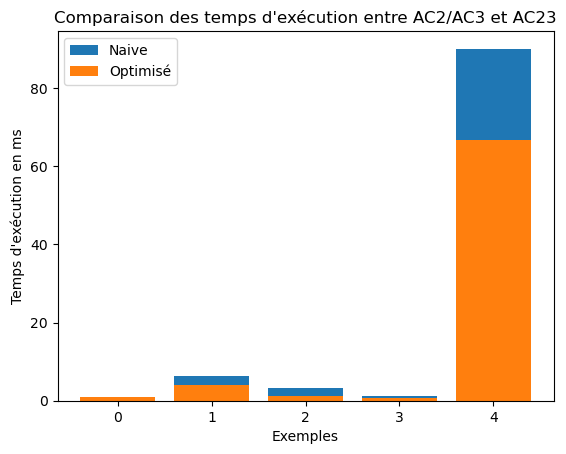

Text(0.5, 1.0, "Comparaison des temps d'exécution entre AC2/AC3 et AC23")

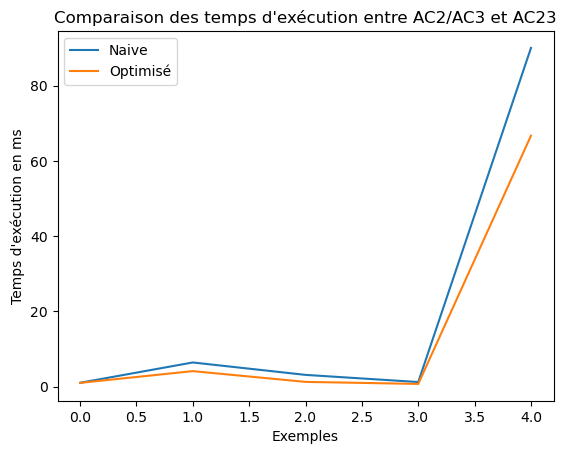

In [69]:

list_duree=[]
list_duree_opt=[]
list_id=[1,2,4,1,6]
list_X=[{"S1": 15}, {"S1": 11, "S5": 10}, {"S5": 11, "BDD": 0}, {"Logique":"1", 'BDD':"1"}, {"S1":"0", 'S2':"1", 'S3':"0"} ]
list_y=['A', 'R', 'R', 'A', 'R']

for id, X, y in zip(list_id,list_X, list_y ):
    duree_moy=0
    for repetition in range(50):
        start_time=time.time()
        model.AC2(id, X, y)
        model.AC3(id, X, y)
        duree=int((time.time()-start_time)*1000)
        duree_moy+=duree
    list_duree.append(duree_moy/50)

    duree_moy=0
    for repetition in range(50):
        start_time=time.time()
        model.AC23(id, X, y)
        duree=int((time.time()-start_time)*1000)
        duree_moy+=duree
    list_duree_opt.append(duree_moy/50)

print("Temps d'execution de la version naive", list_duree)
print("Temps d'execution de la version optimisée", list_duree_opt)
plt.bar(list(range(len(list_id))), list_duree, label="Naive")
plt.bar(list(range(len(list_id))), list_duree_opt, label="Optimisé")
plt.legend()
plt.xlabel("Exemples")
plt.ylabel("Temps d'exécution en ms")
plt.title("Comparaison des temps d'exécution entre AC2/AC3 et AC23")
plt.show()

plt.plot(list(range(len(list_id))), list_duree, label="Naive")
plt.plot(list(range(len(list_id))), list_duree_opt, label="Optimisé")
plt.legend()
plt.xlabel("Exemples")
plt.ylabel("Temps d'exécution en ms")
plt.title("Comparaison des temps d'exécution entre AC2/AC3 et AC23")

In [70]:
# start_time=time.time()
# assert model.AC2(5, {"Moyenne": 0, 'Eligible':False},'R')
# assert model.AC3(5, {"Moyenne": 0, 'Eligible':False},'R')
# duree=int((time.time()-start_time)*1000)
# print(duree)

# start_time=time.time()
# assert model.AC23(5, {"Moyenne": 0, 'Eligible':False},'R')
# duree=int((time.time()-start_time)*1000)
# print(duree)

### BC12_beta2 vs BC1

In [104]:
def generate_supersets(N, X, V, df):
	candidat = df[df['id']==N]
	V_sauf_X=[var for var in V if not var in X.keys()]
	#print(V_sauf_X)
	supersets = [X]
	for var in V_sauf_X:
		valeur = candidat[var].iloc[0]
		copie = copy.deepcopy(supersets)
		for dictio in copie:
			dictio[var]= valeur
		supersets =supersets + copie
	unique_dicts = {tuple(sorted(d.items())) for d in supersets}
	unique_list_of_dicts = [dict(item) for item in unique_dicts]
	return sorted(unique_list_of_dicts, key=lambda x:len(x))

def BC1(N, X, decision, df=df, model=model):
	supersets = generate_supersets(N, X, V, df)
	for superset in tqdm(supersets):
		#print("\n",superset)
		if (model.AC1(N, superset, decision) and model.AC2(N, superset, decision) and model.AC3(N, superset, decision)):
			print(f"La actual cause est: {superset} \n")
			return True
	return False


def BC_naive(id1, id2, X, y, verbose=False, model=model, df=df):
	return BC1(id1, X[0], y[0], df) and BC1(id2, X[1], y[1], df) and model.BC1_4(id1, id2, X, y,verbose=verbose)


  0%|          | 0/64 [00:00<?, ?it/s]


La actual cause est: {'S2': '13'} 



  0%|          | 0/64 [00:00<?, ?it/s]


La actual cause est: {'S2': '5'} 



  0%|          | 0/64 [00:00<?, ?it/s]


La actual cause est: {'S1': '15'} 



  0%|          | 0/64 [00:00<?, ?it/s]


La actual cause est: {'S1': '14'} 



  0%|          | 0/64 [00:00<?, ?it/s]


La actual cause est: {'S5': '13'} 



  0%|          | 0/64 [00:00<?, ?it/s]


La actual cause est: {'S5': '13'} 



  0%|          | 0/32 [00:00<?, ?it/s]


La actual cause est: {'BDD': '0', 'Logique': '0'} 



100%|██████████| 127/127 [00:07<00:00, 17.38it/s]


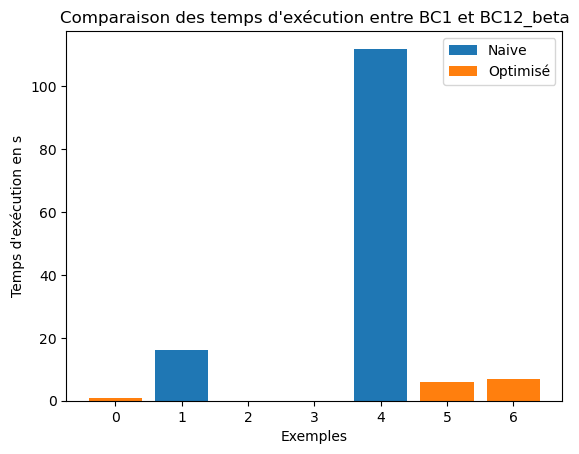

Text(0.5, 1.0, "Comparaison des temps d'exécution entre BC1 et BC12_beta")

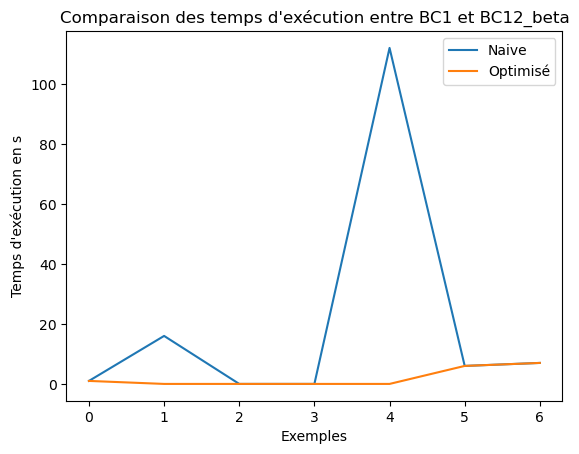

In [108]:
list_duree=[]
list_duree_opt=[]
list_id=[(1,2), (1,3), (1,3), (1,3), (4,5), (3,4), (3,4)]
list_X=[({"S2":"13"}, {"S2":"5"}), ({"S1":"15", 'S2':'13'}, {"S1":"14", 'S2':'12'}), ({"S1":"15"}, {"S1":"14"}), ({"S5":"13"}, {"S5":"13"}), 
        ({"Logique":"0", 'BDD':"0"}, {"Logique":"0", "BDD":'0'}), ({"Logique":"1", 'BDD':"1", 'S2':"12"}, {"Logique":"0", "BDD":'0', 'S2':"15"}), ({"Logique":"1", 'BDD':"1"}, {"Logique":"0", "BDD":'0'})]
list_y=[('A', 'R'), ('A', 'L'), ('A', 'L'), ('A', 'L'), ('R', 'R'), ('L', 'R'), ('L', 'R')]


for id, X, y in zip(list_id,list_X, list_y ):
    nb_repetitions=1
    duree_moy=0
    for repetition in range(nb_repetitions):
        start_time=time.time()
        BC_naive(id[0],id[1], X, y)
        duree=int((time.time()-start_time))
        duree_moy+=duree
    list_duree.append(duree_moy/nb_repetitions)

    duree_moy=0
    for repetition in range(nb_repetitions):
        start_time=time.time()
        model.BC(id[0],id[1], X, y)
        duree=int((time.time()-start_time))
        duree_moy+=duree
    list_duree_opt.append(duree_moy/nb_repetitions)


print("Temps d'execution de la version naive", list_duree)
print("Temps d'execution de la version optimisée", list_duree_opt)
plt.bar(list(range(1,len(list_id)+1)), list_duree, label="Naive")
plt.bar(list(range(1,len(list_id)+1)), list_duree_opt, label="Optimisé")
plt.legend()
plt.xlabel("Exemples")
plt.ylabel("Temps d'exécution en s")
plt.title("Comparaison des temps d'exécution entre BC1 et BC12_beta")
plt.show()

plt.plot(list(range(1,len(list_id)+1)), list_duree, label="Naive")
plt.plot(list(range(1,len(list_id)+1)), list_duree_opt, label="Optimisé")
plt.legend()
plt.xlabel("Exemples")
plt.ylabel("Temps d'exécution en s")
plt.title("Comparaison des temps d'exécution entre BC1 et BC12_beta")


### BC1_4 vs BC3/BC4

In [114]:
def BC3(X,df=df):
  print(set(X[0].keys()) == set(X[1].keys()),(set(X[0].items()) & set(X[1].items())))
  return set(X[0].keys()) == set(X[1].keys()) and (set(X[0].items()) & set(X[1].items())) == set()

def BC4(N_candidats, X, decisions, df=df, model=model):
	def BCi1_3(N_candidats, X, decisions, df=df):
		return BC1(N_candidats[0], X[0], decisions[0], df) and BC1(N_candidats[1], X[1], decisions[1], df) and BC3(X, df)

	# S'assurer que X verifie tous les Bci1-3
	if not BCi1_3(N_candidats, X, decisions, df):
		return False

	candidat1=df[df.id==N_candidats[0]].copy()
	candidat2=df[df.id==N_candidats[1]].copy()
	X1=X[0]
	X2=X[1]
	X_var1=list(X1.keys())
	X_var2=list(X2.keys())

	V_var=list(candidat1.columns)[1:-1] # Prendre toutes les variables qui décrivent un candidat1 sauf N_candidat et Décision

	if X_var1 != X_var2 : # les deux candidats doivent etre testés sur les memes attributs (X)
		return False

	X_var=X_var1
	V_minus_X_var=[var for var in V_var if not var in X_var]

	# Trouver toutes les combinaisons possibles de longueur 1 à la longueur de la liste
	all_combinaisons_var = []

	for nb_var in range(1, len(V_minus_X_var) + 1):
			all_combinaisons_var.extend(combinations(V_minus_X_var, nb_var))

	for var in tqdm(all_combinaisons_var):
		# Remise à l'état initial des sur-ensemble de X1 et X2
		X1_eval=X1.copy()
		X2_eval=X2.copy()
		for v in var:
			X1_eval.update({v: candidat1.iloc[0, candidat1.columns.get_loc(v)]})
			X2_eval.update({v: candidat2.iloc[0, candidat2.columns.get_loc(v)]})
		X_eval=(X1_eval,X2_eval)
	
		if (BCi1_3(N_candidats, X_eval, decisions, df)):
			return False # Retourner False car on aurait trouvé un superset qui verifie tous les BC1-3

	return True
display(df)
BC4((1,4), ({"Logique":"1"}, {"Logique":"0"}), ('A', 'R')) # Crash : RAM insuffisante

,id,S1,S2,S3,S4,S5,Logique,BDD,PS,y
0,1,15,13,16,17,13,1,1,1,A
1,2,11,5,8,12,10,1,1,1,R
2,3,14,12,11,15,13,1,1,1,L
3,4,16,15,15,18,15,0,0,1,R
4,5,11,11,11,11,11,0,0,0,R
5,6,0,1,0,0,0,1,1,1,R
6,7,1,0,0,0,0,1,1,1,R


  0%|          | 0/64 [00:00<?, ?it/s]


La actual cause est: {'Logique': '1'} 



  8%|▊         | 5/64 [00:00<00:00, 375.75it/s]


La actual cause est: {'BDD': 0, 'Logique': '0'} 

True set()


  2%|▏         | 3/127 [00:42<29:01, 14.04s/it]


KeyboardInterrupt: 